<a href="https://colab.research.google.com/github/MDIL-SNU/SevenNet/blob/tutorial/tutorial/SevenNet_python_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SevenNet tutorial: python interactive
---
This notebook is a python interactive tutorial for SevenNet.\
[paper](https://pubs.acs.org/doi/10.1021/acs.jctc.4c00190)\
[code](https://github.com/MDIL-SNU/SevenNet) \
We recommend using a GPU. If you're using Colab, go to:\
[Runtime] -> [Change runtime type] -> [T4 GPU] -> [Save]

If you're using Colab, it may crash occasionally. If it does, try starting from the beginning or from the cell where it crashed. If that doesn’t work, go to: \
[Runtime] -> [Disconnect and delete runtime] -> restart!

## 0. Installation
First of all, let's install SevenNet to our computer!

In [4]:
# Install SevenNet
!pip install sevenn

# If you want to check the SevenNet code, clone the repo.
# !git clone https://github.com/MDIL-SNU/SevenNet.git

import os
working_dir = os.getcwd() # save current path

In [5]:
# check if sevenn is installed well
import sevenn
sevenn.__version__

'0.10.1'

## 1. Dataset

In [6]:
# download the dataset
!git clone https://github.com/MDIL-SNU/sevennet_tutorial.git


fatal: destination path 'sevennet_tutorial' already exists and is not an empty directory.


## 2. Training from scratch

### Dataset setting

In [7]:
from sevenn.train.graph_dataset import SevenNetGraphDataset

dataset_prefix = './sevennet_tutorial/data/train/'
xyz_files = ['1200K.extxyz', '600K.extxyz']
dataset_files = [os.path.join(dataset_prefix, xyz) for xyz in xyz_files]

# Preprocess(build graphs) data before training. It will automatically saves processed graph to {root}/sevenn_data/train.pt, metadata + statistics as train.yaml
dataset = SevenNetGraphDataset(cutoff=5.0, root=working_dir, files=dataset_files, processed_name='train.pt')

print(f'# graphs: {len(dataset)}')
print(f'# atoms (nodes): {dataset.natoms}')
print(dataset[0])

# graphs: 170
# atoms (nodes): {'Cl': 5440, 'Li': 32640, 'P': 5440, 'S': 27200, 'total': 70720}
AtomGraphData(
  x=[416],
  edge_index=[2, 11254],
  pos=[416, 3],
  node_attr=[416],
  atomic_numbers=[416],
  edge_vec=[11254, 3],
  total_energy=[1],
  force_of_atoms=[416, 3],
  stress=[1, 6],
  cell_lattice_vectors=[3, 3],
  pbc_shift=[11254, 3],
  cell_volume=[1],
  num_atoms=[1],
  per_atom_energy=[1],
  data_info={}
)


/usr/local/lib/python3.10/dist-packages/torch_geometric/io/fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([AtomGraphData])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [8]:
from torch_geometric.loader import DataLoader

# split the dataset into train & valid
num_dataset = len(dataset)
num_train = int(num_dataset * 0.95)
num_valid = num_dataset - num_train

dataset = dataset.shuffle()
train_dataset = dataset[:num_train]
valid_dataset = dataset[num_train:]

print(f'# graphs for training: {len(train_dataset)}')
print(f'# graphs for validation: {len(valid_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8)

# graphs for training: 161
# graphs for validation: 9


### Model setting

In [9]:
from copy import deepcopy

from sevenn._const import DEFAULT_E3_EQUIVARIANT_MODEL_CONFIG
from sevenn.model_build import build_E3_equivariant_model
import sevenn.util as util

train_shift = dataset.per_atom_energy_std
train_scale = dataset.force_rms
train_conv_denominator = dataset.avg_num_neigh

# copy default model configuration.
model_cfg = deepcopy(DEFAULT_E3_EQUIVARIANT_MODEL_CONFIG)

# tell models about element in universe
model_cfg.update(util.chemical_species_preprocess([], universal=True))

# tell model about statistics of dataset. kind of data standardization
model_cfg.update({'shift': train_shift, 'scale': train_scale, 'conv_denominator': train_conv_denominator})

model = build_E3_equivariant_model(model_cfg)
num_weights = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model) # model info
print(f'# model weights: {num_weights}')

AtomGraphSequential(
  (edge_embedding): EdgeEmbedding(
    (basis_function): BesselBasis()
    (cutoff_function): PolynomialCutoff()
    (spherical): SphericalEncoding(
      (sph): SphericalHarmonics()
    )
  )
  (onehot_idx_to_onehot): OnehotEmbedding()
  (onehot_to_feature_x): IrrepsLinear(
    (linear): Linear(119x0e -> 32x0e | 3808 weights)
  )
  (0_self_connection_intro): SelfConnectionIntro(
    (fc_tensor_product): FullyConnectedTensorProduct(32x0e x 119x0e -> 64x0e+32x1o | 243712 paths | 243712 weights)
  )
  (0_self_interaction_1): IrrepsLinear(
    (linear): Linear(32x0e -> 32x0e | 1024 weights)
  )
  (0_convolution): IrrepsConvolution(
    (convolution): TensorProduct(32x0e x 1x0e+1x1o -> 32x0e+32x1o | 64 paths | 64 weights)
    (weight_nn): FullyConnectedNet[8, 64, 64, 64]
  )
  (0_self_interaction_2): IrrepsLinear(
    (linear): Linear(32x0e+32x1o -> 64x0e+32x1o | 3072 weights)
  )
  (0_self_connection_outro): SelfConnectionOutro()
  (0_equivariant_gate): EquivariantGat

### Start training
If you want more accurate model, increase the num_epoch!

In [10]:
from sevenn._const import DEFAULT_TRAINING_CONFIG
from sevenn.train.trainer import Trainer

# copy default training configuration
train_cfg = deepcopy(DEFAULT_TRAINING_CONFIG)

# set optimizer and scheduler for training.
train_cfg.update({
  'device': 'cuda',
  'optimizer': 'adam',
  'optim_param': {'lr': 0.005},
  'scheduler': 'exponentiallr',
  'scheduler_param': {'gamma': 0.99},
})

# Initialize trainer. It implements common rountines for training.
trainer = Trainer.from_config(model, train_cfg)
print(trainer.loss_functions)  # We have energy, force, stress loss function by defaults. With default 1.0, 0.1, and 1e-6 loss weight
print(trainer.optimizer)
print(trainer.scheduler)
print(trainer.scheduler.gamma)

[(Energy, 1.0), (Force, 0.1), (Stress, 1e-06)]
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.005
    lr: 0.005
    maximize: False
    weight_decay: 0
)
0.99


In [11]:
from sevenn.error_recorder import ErrorRecorder

train_cfg.update({
  # List of tuple [Quantity name, metric name]
  # Supporting quantities: Energy, Force, Stress, Stress_GPa
  # Supporting metrics: RMSE, MAE, Loss
  # TotalLoss is special!
  'error_record': [
    ('Energy', 'RMSE'),
    ('Force', 'RMSE'),
    # ('Stress', 'RMSE'),  We skip stress error cause it is too long to print, uncomment it if you want
    ('TotalLoss', 'None'),
  ]
})
train_recorder = ErrorRecorder.from_config(train_cfg)
valid_recorder = deepcopy(train_recorder)
for metric in train_recorder.metrics:
  print(metric)

Energy_RMSE (eV/atom): nan
Force_RMSE (eV/Å): nan
TotalLoss: nan


In [12]:
from tqdm import tqdm

valid_best = float('inf')
total_epoch = 50
pbar = tqdm(range(total_epoch))
config = model_cfg  # to save config used in this tutorial.
config.update(train_cfg)

for epoch in pbar:
  # trainer scans whole data from given loader, and updates error recorder with outputs.
  trainer.run_one_epoch(train_loader, is_train=True, error_recorder=train_recorder)
  trainer.run_one_epoch(valid_loader, is_train=False, error_recorder=valid_recorder)
  train_err = train_recorder.epoch_forward()  # return averaged error over one epoch, then reset.
  valid_err = valid_recorder.epoch_forward()

  # for print. train_err is a dictionary of {metric name with unit: error}
  err_str = 'Train: ' + '    '.join([f'{k}: {v:.3f}' for k, v in train_err.items()])
  err_str += '// Valid: ' + '    '.join([f'{k}: {v:.3f}' for k, v in valid_err.items()])
  pbar.set_description(err_str)

  if valid_err['TotalLoss'] < valid_best:  # saves best checkpoint. by comparing validation set total loss
    valid_best = valid_err['TotalLoss']
    trainer.write_checkpoint(os.path.join(working_dir, 'checkpoint_best.pth'), config=config, epoch=epoch)

Train: Energy_RMSE (eV/atom): 0.015    Force_RMSE (eV/Å): 0.494    TotalLoss: 0.008// Valid: Energy_RMSE (eV/atom): 0.021    Force_RMSE (eV/Å): 0.546    TotalLoss: 0.011: 100%|██████████| 50/50 [04:10<00:00,  5.01s/it]


## 3. Model test
### Energy / force plot
Let's predict the energy and force of training/test dataset and draw the parity plots

In [13]:
# load test model
import torch
import ase.io

from sevenn.sevennet_calculator import SevenNetCalculator

# Let's test our model by predicting DFT MD trajectory
# Instead of using other functions in SevenNet, we will use ASE calculator as an interface of our model
DFT_md_xyz = './sevennet_tutorial/data/evaluation/test_md.extxyz'

# initialize calculator from checkpoint.
sevennet_calc = SevenNetCalculator(os.path.join(working_dir, 'checkpoint_best.pth'))

# load DFT md trajectory
traj = ase.io.read(DFT_md_xyz, index=':')

In [14]:
import numpy as np

dft_energy = []
dft_forces = []
dft_stress = []

mlp_energy = []
mlp_forces = []
mlp_stress = []
to_kBar = 1602.1766208

for atoms in tqdm(traj):
  atoms.calc = sevennet_calc
  mlp_energy.append(atoms.get_potential_energy() / len(atoms))  # as per atom energy
  mlp_forces.append(atoms.get_forces())
  mlp_stress.extend(atoms.get_stress() * to_kBar)  # eV/Angstrom^3 to kBar unit

  dft_energy.append(atoms.info['DFT_energy'] / len(atoms))
  dft_forces.append(atoms.arrays['DFT_forces'])
  dft_stress.append(atoms.info['DFT_stress'] * to_kBar)


100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


In [15]:
# flatten forces and stress for parity plot
mlp_forces = np.concatenate([mf.reshape(-1,) for mf in mlp_forces])
mlp_stress = np.concatenate([ms.reshape(-1,) for ms in mlp_stress])

dft_forces = np.concatenate([df.reshape(-1,) for df in dft_forces])
dft_stress = np.concatenate([ds.reshape(-1,) for ds in dft_stress])

In [ ]:
train_ans_energy = train_dataset.per_atom_energy
train_ans_force = train_dataset.force_of_atoms
train_pred_energy = []
train_pred_force = []

test_ans_energy = test_dataset.per_atom_energy
test_ans_force = test_dataset.force_of_atoms
test_pred_energy = []
test_pred_force = []

for step, batch in tqdm(enumerate(iter(train_loader))):
  batch.to(device)
  output = model(batch)
  train_pred_energy.append(output.inferred_total_energy/output.num_atoms)
  train_pred_force.append(output.inferred_force)

for step, batch in tqdm(enumerate(iter(test_loader))):
  batch.to(device)
  output = model(batch)
  test_pred_energy.append(output.inferred_total_energy/output.num_atoms)
  test_pred_force.append(output.inferred_force)

train_pred_energy = torch.cat(train_pred_energy, dim=0)
train_pred_force = torch.cat(train_pred_force, dim=0)
test_pred_energy = torch.cat(test_pred_energy, dim=0)
test_pred_force = torch.cat(test_pred_force, dim=0)

14it [00:01,  7.86it/s]
2it [00:00,  7.01it/s]


Text(-5.157461166381836, 4.60947322845459, 'R²: 0.56')

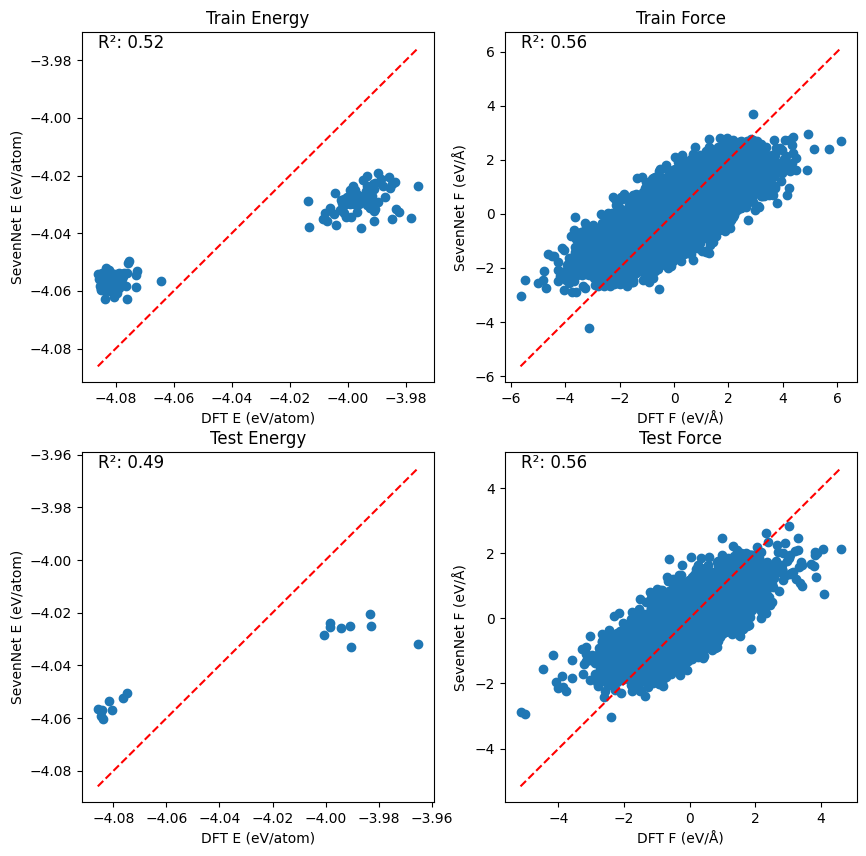

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

train_ans_energy_np = train_ans_energy.cpu().numpy()
train_pred_energy_np = train_pred_energy.detach().cpu().numpy()
train_ans_force_np = train_ans_force.flatten().cpu().numpy()
train_pred_force_np = train_pred_force.flatten().cpu().numpy()

test_ans_energy_np = test_ans_energy.cpu().numpy()
test_pred_energy_np = test_pred_energy.detach().cpu().numpy()
test_ans_force_np = test_ans_force.flatten().cpu().numpy()
test_pred_force_np = test_pred_force.flatten().cpu().numpy()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# train energy plot
ax1.scatter(train_ans_energy_np, train_pred_energy_np)
min_val = min(min(train_ans_energy_np), min(train_pred_energy_np))
max_val = max(max(train_ans_energy_np), max(train_pred_energy_np))
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
ax1.set_xlabel("DFT E (eV/atom)")
ax1.set_ylabel("SevenNet E (eV/atom)")
ax1.set_title("Train Energy")

r2_energy_train = r2_score(train_ans_energy_np, train_pred_energy_np)
ax1.text(min_val, max_val, f"R²: {r2_energy_train:.2f}", fontsize=12)

# train force plot
ax2.scatter(train_ans_force_np, train_pred_force_np)
min_val = min(min(train_ans_force_np), min(train_pred_force_np))
max_val = max(max(train_ans_force_np), max(train_pred_force_np))
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
ax2.set_xlabel("DFT F (eV/Å)")
ax2.set_ylabel("SevenNet F (eV/Å)")
ax2.set_title("Train Force")

r2_force_train = r2_score(train_ans_force_np, train_pred_force_np)
ax2.text(min_val, max_val, f"R²: {r2_force_train:.2f}", fontsize=12)

# test energy plot
ax3.scatter(test_ans_energy_np, test_pred_energy_np)
min_val = min(min(test_ans_energy_np), min(test_pred_energy_np))
max_val = max(max(test_ans_energy_np), max(test_pred_energy_np))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
ax3.set_xlabel("DFT E (eV/atom)")
ax3.set_ylabel("SevenNet E (eV/atom)")
ax3.set_title("Test Energy")

r2_energy_test = r2_score(test_ans_energy_np, test_pred_energy_np)
ax3.text(min_val, max_val, f"R²: {r2_energy_test:.2f}", fontsize=12)

# test force plot
ax4.scatter(test_ans_force_np, test_pred_force_np)
min_val = min(min(test_ans_force_np), min(test_pred_force_np))
max_val = max(max(test_ans_force_np), max(test_pred_force_np))
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
ax4.set_xlabel("DFT F (eV/Å)")
ax4.set_ylabel("SevenNet F (eV/Å)")
ax4.set_title("Test Force")

r2_force_test = r2_score(test_ans_force_np, test_pred_force_np)
ax4.text(min_val, max_val, f"R²: {r2_force_test:.2f}", fontsize=12)

## Structure relaxation

We can perform structure relaxation using the ASE library with the model we've trained.

In [ ]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from ase.io import read, write
from ase.constraints import UnitCellFilter
from ase.optimize import LBFGS

from sevenn.sevennet_calculator import SevenNetCalculator

# relaxation path
os.makedirs('seven_python_tuto/relaxation', exist_ok=True)
working_dir = os.getcwd()
training_dir = os.path.join(working_dir, 'seven_python_tuto')
checkpoint_dir = os.path.join(training_dir, 'checkpoint')
relaxation_dir = os.path.join(training_dir, 'relaxation')
shutil.copy(os.path.join(working_dir, 'data/relaxation/LPSC.cif'), relaxation_dir)

# load the trained model
checkpoint_best_path = os.path.join(checkpoint_dir, 'checkpoint_best.pth')
seven_calc = SevenNetCalculator(checkpoint_best_path, device='cuda')
# seven_calc = SevenNetCalculator(device='cuda')     # you can use 7net-0 using this code. Compare the result!

# read the structure
initial_structure_path = os.path.join(relaxation_dir, 'LPSC.cif')
structure = read(initial_structure_path)

# set the calculator
structure.calc = seven_calc

# print initial energy and force
energy = structure.get_potential_energy()
forces = structure.get_forces()
print('Initial energy: ', energy, 'eV')
print('Initial force: ', np.max(np.linalg.norm(forces, axis=1)))
print('---------------------------------------------------------')

# add UnitCellFilter -> optimizing positions and unit cell simultaneously
ucf = UnitCellFilter(structure)

# set optimizer. You can use other optimizers. We use LBFGS here.
logfile_path = os.path.join(relaxation_dir, 'LPSC_relax.log')
with open(logfile_path, 'w') as f:
  pass # clear the logfile
opt = LBFGS(ucf, logfile=logfile_path)
opt.run(fmax=0.02, steps=100)

# write the relaxed structure
relaxed_structure_path = os.path.join(relaxation_dir, 'LPSC_relaxed.cif')
write(relaxed_structure_path, structure)

# print the final energy and force
energy = structure.get_potential_energy()
forces = structure.get_forces()
print('Final energy: ', energy, 'eV')
print('Final force: ', np.max(np.linalg.norm(forces, axis=1)))

Initial energy:  -1703.043212890625 eV
Initial force:  0.6987558
---------------------------------------------------------
Final energy:  -1767.8045654296875 eV
Final force:  9.668269


Let's check the initial and relaxed structure.

In [ ]:
# libraries for visualization
!pip install pymatgen
!pip install py3Dmol

In [ ]:
import py3Dmol
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter

# visualize the initial structure
view1 = py3Dmol.view(width=400, height=400)
structure1 = Structure.from_file(initial_structure_path)
cif_writer1 = CifWriter(structure1)
cif_string1 = cif_writer1.__str__()

print('Initial LPSC structure')
view1.setStyle({'cartoon':{'color':'spectrum'}})
view1.addModel(cif_string1, 'cif')
view1.setStyle(
    {"elem": "Li"}, {"stick": {"color": "lime"}, "sphere": {"color": "lime", "scale": 0.3}}
)
view1.setStyle(
    {"elem": "P"}, {"stick": {"color": "purple"}, "sphere": {"color": "purple", "scale": 0.3}}
)
view1.setStyle(
    {"elem": "S"}, {"stick": {"color": "yellow"}, "sphere": {"color": "yellow", "scale": 0.3}}
)
view1.setStyle(
    {"elem": "Cl"}, {"stick": {"color": "green"}, "sphere": {"color": "green", "scale": 0.3}}
)
view1.addUnitCell()
view1.zoomTo()
view1.show()

# visualize the final structure
view2 = py3Dmol.view(width=400, height=400)
structure2 = Structure.from_file(relaxed_structure_path)
cif_writer2 = CifWriter(structure2)
cif_string2 = cif_writer2.__str__()

print('Final LPSC structure')
view2.setStyle({'cartoon':{'color':'spectrum'}})
view2.addModel(cif_string2, 'cif')
view2.setStyle(
    {"elem": "Li"}, {"stick": {"color": "lime"}, "sphere": {"color": "lime", "scale": 0.3}}
)
view2.setStyle(
    {"elem": "P"}, {"stick": {"color": "purple"}, "sphere": {"color": "purple", "scale": 0.3}}
)
view2.setStyle(
    {"elem": "S"}, {"stick": {"color": "yellow"}, "sphere": {"color": "yellow", "scale": 0.3}}
)
view2.setStyle(
    {"elem": "Cl"}, {"stick": {"color": "green"}, "sphere": {"color": "green", "scale": 0.3}}
)
view2.addUnitCell()
view2.zoomTo()
view2.show()


Initial LPSC structure


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Final LPSC structure


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

How about a pretrained model? Let's compare the result with SevenNet-0

In [ ]:
import os
import shutil
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from ase.io import read, write
from ase.constraints import UnitCellFilter
from ase.optimize import LBFGS

from sevenn.sevennet_calculator import SevenNetCalculator

# relaxation path
os.makedirs('seven_python_tuto/relaxation', exist_ok=True)
working_dir = os.getcwd()
training_dir = os.path.join(working_dir, 'seven_python_tuto')
checkpoint_dir = os.path.join(training_dir, 'checkpoint')
relaxation_dir = os.path.join(training_dir, 'relaxation')

# load the trained model
seven_calc = SevenNetCalculator(device='cuda')

# read the structure
initial_structure_path = os.path.join(relaxation_dir, 'LPSC.cif')
structure = read(initial_structure_path)

# set the calculator
structure.calc = seven_calc

# print initial energy and force
energy = structure.get_potential_energy()
forces = structure.get_forces()
print('Initial energy: ', energy, 'eV')
print('Initial force: ', np.max(np.linalg.norm(forces, axis=1)))
print('---------------------------------------------------------')

# add UnitCellFilter -> optimizing positions and unit cell simultaneously
ucf = UnitCellFilter(structure)

# set optimizer. You can use other optimizers. We use LBFGS here.
logfile_path = os.path.join(relaxation_dir, 'LPSC_relax_7net0.log')
with open(logfile_path, 'w') as f:
  pass # clear the logfile
opt = LBFGS(ucf, logfile=logfile_path)
opt.run(fmax=0.02, steps=100)

# write the relaxed structure
relaxed_structure_7net0_path = os.path.join(relaxation_dir, 'LPSC_relaxed_7net0.cif')
write(relaxed_structure_7net0_path, structure)

# print the final energy and force
energy = structure.get_potential_energy()
forces = structure.get_forces()
print('Final energy: ', energy, 'eV')
print('Final force: ', np.max(np.linalg.norm(forces, axis=1)))

Initial energy:  -1730.915771484375 eV
Initial force:  0.19570129
---------------------------------------------------------
Final energy:  -1731.481689453125 eV
Final force:  0.05974072


In [ ]:
import py3Dmol
from pymatgen.core import Structure
from pymatgen.io.cif import CifWriter

# visualize the initial structure
view1 = py3Dmol.view(width=400, height=400)
structure1 = Structure.from_file(initial_structure_path)
cif_writer1 = CifWriter(structure1)
cif_string1 = cif_writer1.__str__()

print('Initial LPSC structure')
view1.setStyle({'cartoon':{'color':'spectrum'}})
view1.addModel(cif_string1, 'cif')
view1.setStyle(
    {"elem": "Li"}, {"stick": {"color": "lime"}, "sphere": {"color": "lime", "scale": 0.3}}
)
view1.setStyle(
    {"elem": "P"}, {"stick": {"color": "purple"}, "sphere": {"color": "purple", "scale": 0.3}}
)
view1.setStyle(
    {"elem": "S"}, {"stick": {"color": "yellow"}, "sphere": {"color": "yellow", "scale": 0.3}}
)
view1.setStyle(
    {"elem": "Cl"}, {"stick": {"color": "green"}, "sphere": {"color": "green", "scale": 0.3}}
)
view1.addUnitCell()
view1.zoomTo()
view1.show()

# visualize the final structure
view2 = py3Dmol.view(width=400, height=400)
structure2 = Structure.from_file(relaxed_structure_7net0_path)
cif_writer2 = CifWriter(structure2)
cif_string2 = cif_writer2.__str__()

print('Final LPSC structure')
view2.setStyle({'cartoon':{'color':'spectrum'}})
view2.addModel(cif_string2, 'cif')
view2.setStyle(
    {"elem": "Li"}, {"stick": {"color": "lime"}, "sphere": {"color": "lime", "scale": 0.3}}
)
view2.setStyle(
    {"elem": "P"}, {"stick": {"color": "purple"}, "sphere": {"color": "purple", "scale": 0.3}}
)
view2.setStyle(
    {"elem": "S"}, {"stick": {"color": "yellow"}, "sphere": {"color": "yellow", "scale": 0.3}}
)
view2.setStyle(
    {"elem": "Cl"}, {"stick": {"color": "green"}, "sphere": {"color": "green", "scale": 0.3}}
)
view2.addUnitCell()
view2.zoomTo()
view2.show()


Initial LPSC structure


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Final LPSC structure


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Our model trained from scratch didn’t perform well in ASE relaxation compared to pretrained model. To address this, we have two strategies to consider:
1. **Increase the size of the dataset**: We trained with only about 130 data points, which is likely insufficient for an accurate model. By increasing the dataset size and training for more epochs, we can improve the model’s performance. But what if we only have a limited amount of data?
2. **Fine-Tuning**: We can fine-tune a pretrained model to improve its accuracy efficiently with limited data. Let’s explore this approach in the next tutorial!